In [1]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle
np.random.seed(247) # for reproducibility

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer
from lasagne import regularization

from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, CuDNN 4007)


In [2]:
filename = 'Unlocalized_N=100000_S=200_M=50_G=20_data.pickle'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, filename)

# load training set
print "loading data from: " + filepath
f = open(filepath, 'rb')
print "loading train data"
train = cPickle.load(f)
print "loading cross-validation data"
cross_validation = cPickle.load(f)
print "loading test data"
test = cPickle.load(f)
f.close()

X_train = train[0].transpose((0,1,2)).astype(np.float32)
y_train = train[1].astype(np.int32)
X_val = cross_validation[0].transpose((0,1,2)).astype(np.float32)
y_val = cross_validation[1].astype(np.int32)
X_test = test[0].transpose((0,1,2)).astype(np.float32)
y_test = test[1].astype(np.int32)

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

train = (X_train, y_train, train[2])
valid = (X_val, y_val, cross_validation[2])
test = (X_test, y_test, test[2])

shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=50_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [3]:
model_name = "autoencode_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)

In [4]:
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)

Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.31361 -- accuracy=95.87%  
  valid loss:		0.23976
  valid accuracy:	0.96075+/-0.02271
  valid auc-roc:	0.91151+/-0.07249
  valid auc-pr:		0.53847+/-0.31009
saving model parameters to: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=50_G=20_data.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.18653 -- accuracy=97.17%  
  valid loss:		0.18294
  valid accuracy:	0.96884+/-0.01787
  valid auc-roc:	0.95136+/-0.04218
  valid auc-pr:		0.67017+/-0.26942
saving model parameters to: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=50_G=20_data.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.16083 -- accuracy=97.49%  
  valid loss:		0.15420
  valid accuracy:	0.97611+/-0.01610
  valid auc-roc:	0.96373+/-0.03330
  valid auc-pr:		0.71989+/-0.25014
saving model parameters to: /home/peter/Dat

In [5]:
nnmodel.print_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: 
shape:(None, 4, 200, 1)
layer2: 
shape:(None, 64, 192, 1)
parameters: W
layer3: 
shape:(None, 64, 192, 1)
layer4: 
shape:(None, 64, 192, 1)
parameters: beta, gamma, mean, inv_std
layer5: 
shape:(None, 64, 192, 1)
parameters: alpha
layer6: 
shape:(None, 64, 64, 1)
layer7: 
shape:(None, 128, 60, 1)
parameters: W
layer8: 
shape:(None, 128, 60, 1)
layer9: 
shape:(None, 128, 60, 1)
parameters: beta, gamma, mean, inv_std
layer10: 
shape:(None, 128, 60, 1)
parameters: alpha
layer11: 
shape:(None, 128, 60, 1)
layer12: 
shape:(None, 128, 20, 1)
layer13: 
shape:(None, 256, 16, 1)
parameters: W
layer14: 
shape:(None, 256, 16, 1)
layer15: 
shape:(None, 256, 16, 1)
parameters: beta, gamma, mean, inv_std
layer16: 
shape:(None, 256, 16, 1)
parameters: alpha
layer17: 
shape:(None, 256, 16, 1)
layer18: 
shape:(None, 256,

In [6]:
network = nnmodel.network
network

{'conv1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f34a2bb1c90>,
 'conv1_active': <lasagne.layers.special.ParametricRectifierLayer at 0x7f349f7f0f10>,
 'conv1_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7f349f7f0210>,
 'conv1_bias': <lasagne.layers.special.BiasLayer at 0x7f350e6a1f90>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f349f7f0250>,
 'conv2': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f35080ad750>,
 'conv2_active': <lasagne.layers.special.ParametricRectifierLayer at 0x7f349f80da50>,
 'conv2_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7f349f80d4d0>,
 'conv2_bias': <lasagne.layers.special.BiasLayer at 0x7f349f80d390>,
 'conv2_dropout': <lasagne.layers.noise.DropoutLayer at 0x7f349f80d510>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f349f80dc50>,
 'conv3': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f349f80dc90>,
 'conv3_active': <lasagne.layers.special.ParametricRectifierLayer at 0x7f349f8163d0>,
 'conv3_batch': <lasagne.layers.

In [87]:
import pandas as pd
def seq_logo(pwm, height=100, nt_width=20, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)
    
    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    width = np.ceil(nt_width*num_seq).astype(int)
    
    total_height = np.sum(heights,axis=0)
    max_height = np.max(total_height)
    logo = np.ones((height*2, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = total_height[i];
        offset = max_height-remaining_height
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        for j in range(num_nt):
            if nt_height[j] > 0:
                # resized dimensions of image
                resize = (nt_height[j], nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                if height_range:
                    for k in range(3):
                        for m in range(len(width_range)):
                            logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


In [ ]:
def generate_mutagenesis(seq):
    num_alphabet, num_nt = seq.shape

    mut_seq = []
    mut_seq.append(seq)
    for i in range(num_nt):
        for j in range(num_alphabet):
            new_seq = np.copy(seq)
            new_seq[:,i] = 0
            new_seq[j,i] = 1
            mut_seq.append(new_seq)
    mut_seq = np.array(mut_seq)
    return np.expand_dims(mut_seq,3)

def mutagenesis_predictions(X, layer, input_var):
    feature_maps = theano.function([input_var], layers.get_output(layer, deterministic=True), 
                                   allow_input_downcast=True)
    map_shape = get_output_shape(layer)

    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    batch_size = 64
    num_data = len(X)
    num_batches = num_data // batch_size
    shape = list(map_shape)
    shape[0] = num_data
    fmaps = np.empty(tuple(shape))
    for i in range(num_batches):
        index = range(i*batch_size, (i+1)*batch_size)    
        fmaps[index] = feature_maps(X[index])

    # get the rest of the feature maps
    excess = num_data-num_batches*batch_size
    index = range(num_data-excess, num_data)    
    fmaps[index] = feature_maps(X[index])
    return fmaps

def mutagenesis_importance(seq, predictions):
    num_alphabet, num_nt = seq.shape
    baseline = predictions[0]

    importance = np.zeros(seq.shape)
    delta = np.zeros(seq.shape)
    prediction = np.zeros(seq.shape)
    k = 1
    for i in range(num_nt):
        new_seq = np.copy(seq)
        for j in range(num_alphabet):
            delta[j,i] = np.sum(baseline-predictions[k])
            importance[j,i] = np.sum((baseline-predictions[k])**2)
            prediction[j,i] = np.argmax(predictions[k])
            k += 1
    return importance, delta, prediction



TypeError: __init__() got an unexpected keyword argument 'set_ticks'

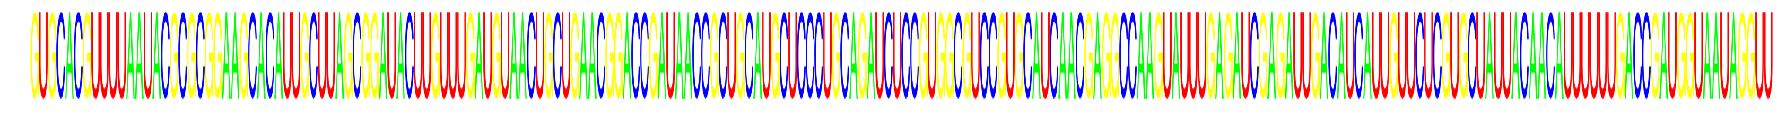

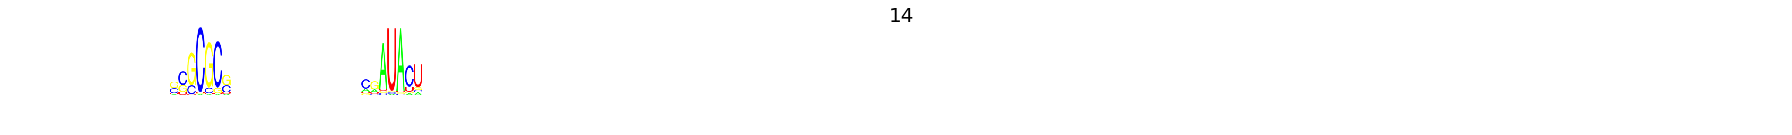

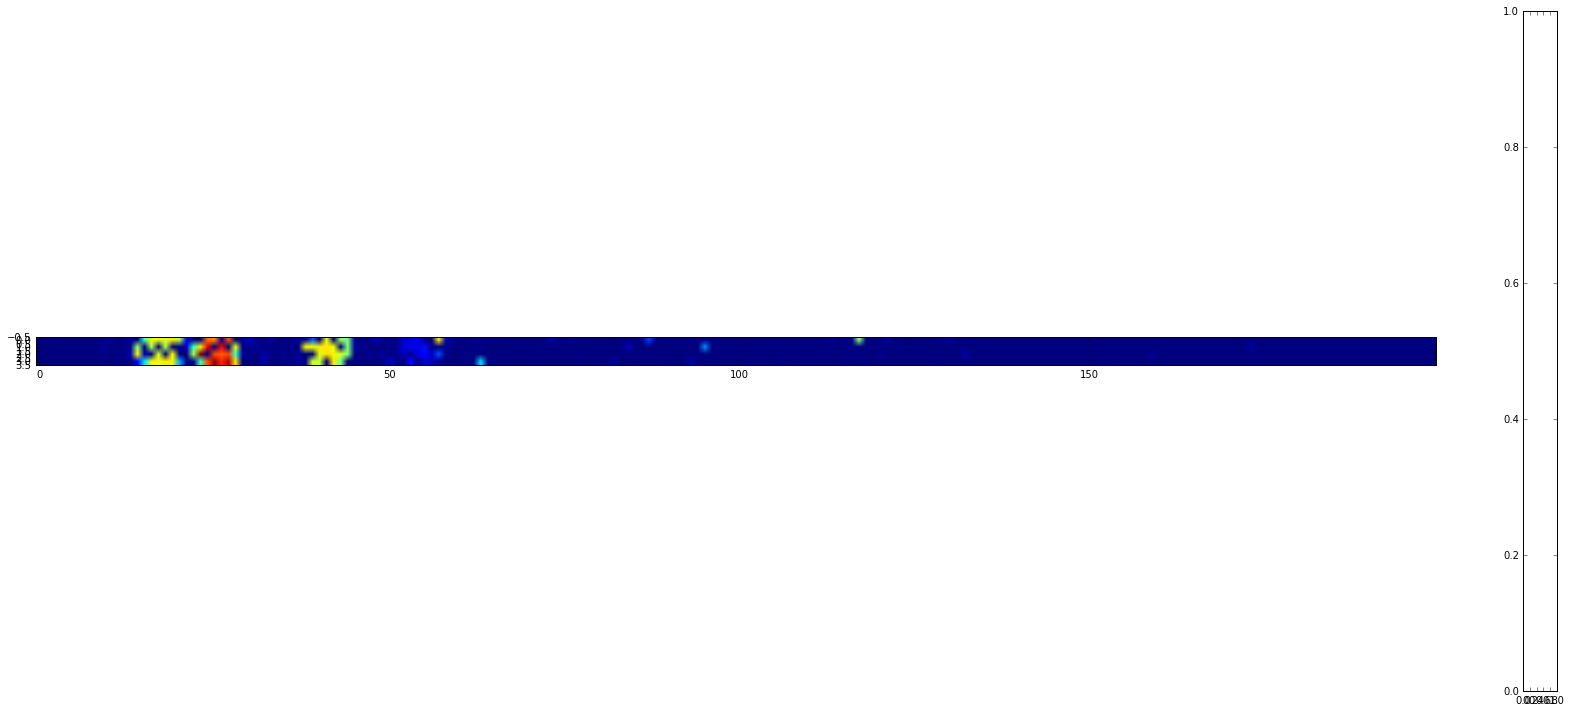

In [168]:
index= 41 # 23, 24, 25, 18, 27, 28, 31, 39
seq = np.squeeze(test[0][index])
true_class = np.argmax(test[1][index,:])
model = test[2][index]

mut_seq = generate_mutagenesis(seq)
predictions = mutagenesis_predictions(mut_seq, network['output'], nnmodel.input_var)
importance, delta, prediction = mutagenesis_importance(seq, predictions)


height=100
bp_width=20
size = (25.,10.0)

logo = seq_logo(seq, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');

logo = seq_logo(model, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');
plt.title(str(true_class),fontsize=20)


plt.figure(figsize=size)
plt.imshow(importance)
plt.colorbar(set_ticks=[0, .1, .2, .3])

plt.figure(figsize=size)
plt.imshow(delta)
plt.colorbar(set_ticks=[-.3, 0, .3])

plt.figure(figsize=size)
plt.imshow((prediction == true_class).astype(int))
plt.colorbar()


# statistical random sampling in windows

In [ ]:
def generate_mutagenesis(seq):
    num_alphabet, num_nt = seq.shape

    mut_seq = []
    mut_seq.append(seq)
    for i in range(num_nt):
        for j in range(num_alphabet):
            new_seq = np.copy(seq)
            new_seq[:,i] = 0
            new_seq[j,i] = 1
            mut_seq.append(new_seq)
    mut_seq = np.array(mut_seq)
    return np.expand_dims(mut_seq,3)

def mutagenesis_predictions(X, layer, input_var):
    feature_maps = theano.function([input_var], layers.get_output(layer, deterministic=True), 
                                   allow_input_downcast=True)
    map_shape = get_output_shape(layer)

    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    batch_size = 64
    num_data = len(X)
    num_batches = num_data // batch_size
    shape = list(map_shape)
    shape[0] = num_data
    fmaps = np.empty(tuple(shape))
    for i in range(num_batches):
        index = range(i*batch_size, (i+1)*batch_size)    
        fmaps[index] = feature_maps(X[index])

    # get the rest of the feature maps
    excess = num_data-num_batches*batch_size
    index = range(num_data-excess, num_data)    
    fmaps[index] = feature_maps(X[index])
    return fmaps

def mutagenesis_importance(seq, predictions):
    num_alphabet, num_nt = seq.shape
    baseline = predictions[0]

    importance = np.zeros(seq.shape)
    delta = np.zeros(seq.shape)
    prediction = np.zeros(seq.shape)
    k = 1
    for i in range(num_nt):
        new_seq = np.copy(seq)
        for j in range(num_alphabet):
            delta[j,i] = np.sum(baseline-predictions[k])
            importance[j,i] = np.sum((baseline-predictions[k])**2)
            prediction[j,i] = np.argmax(predictions[k])
            k += 1
    return importance, delta, prediction

